# Face Generation

In this project, I'll define and train a DCGAN on a dataset of faces. my goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, we'll be able to visualize the results of my trained Generator to see how it performs; the generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

I'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train my adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) we've been working with, and so, I should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that to utilize a GPU for training.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that we'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, there should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
!ls -U processed_celeba_small/celeba | head -5

193276.jpg
168710.jpg
176940.jpg
164254.jpg
181541.jpg
ls: write error: Broken pipe


In [3]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we're going to be generating faces, we won't need the annotations, we'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

There are a few other steps that I'll need to **transform** this data and create a **DataLoader**.

#### Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Our images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Our function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that to use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [4]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    # resize the images
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    
    # define dataset using ImageFolder
    data_set = datasets.ImageFolder(data_dir, transform)
    
    # create and return DataLoader
    data_loader = DataLoader(dataset = data_set, batch_size = batch_size, shuffle = True)
    
    return data_loader


## Create a DataLoader

#### Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* We can decide on any reasonable `batch_size` parameter
* Our `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
# Define function hyperparameters
batch_size = 64
img_size = 32


# Call the function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, we can view some images! We should seen square images of somewhat-centered faces.

Note: I'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

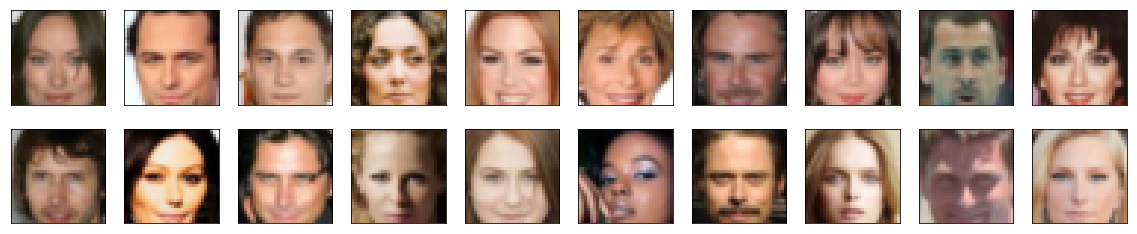

In [7]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process image data and scale it to a pixel range of -1 to 1

We need to do a bit of pre-processing; we know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [9]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.7725)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The first task will be to define the discriminator. This is a convolutional classifier like I've built before, only without any maxpooling layers. To deal with this complex data, it's suggested to use a deep network with **normalization**.

* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        self.conv1 = nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False) # (x,y,d)=(32,32,3) -> (16,16,conv_dim)
        self.batch_norm1 = nn.BatchNorm2d(conv_dim)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False) # (16,16,conv_dim) -> (8,8,conv_dim*2)
        self.batch_norm2 = nn.BatchNorm2d(conv_dim*2)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False) # (8,8,conv_dim*2) -> (4,4,conv_dim*4)
        self.batch_norm3 = nn.BatchNorm2d(conv_dim*4)
        self.conv4 = nn.Conv2d(conv_dim*4, conv_dim*8, kernel_size=4, stride=2, padding=1, bias=False) #(2,2,conv_dim*8)
        self.batch_norm4 = nn.BatchNorm2d(conv_dim*8)
        self.conv5 = nn.Conv2d(conv_dim*8, conv_dim*16, kernel_size=4, stride=2, padding=1, bias=False) #(1,1, conv_dim*16)
        
        # Fully connectedlayer
        self.fc = nn.Linear(conv_dim*16, 1) #(x,y,d) = (1,1,conv_dim*16)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        x = F.leaky_relu(self.batch_norm1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.batch_norm2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.batch_norm3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.batch_norm4(self.conv4(x)), 0.2)
        x = self.conv5(x)
        
        x = x.view(-1, self.conv_dim*16)
        x = self.fc(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4)
        
        self.t_conv1 = nn.ConvTranspose2d(conv_dim, conv_dim*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(conv_dim*8)
        self.t_conv2 = nn.ConvTranspose2d(conv_dim*8, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(conv_dim*4)
        self.t_conv3 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(conv_dim*2)
        self.t_conv4 = nn.ConvTranspose2d(conv_dim*2, 3, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = self.fc(x)
        x = x.view(-1, self.conv_dim, 2, 2) #(batch_size, depth, x, y)
        
        x = F.relu(self.batch_norm1(self.t_conv1(x)))
        x = F.relu(self.batch_norm2(self.t_conv2(x)))
        x = F.relu(self.batch_norm3(self.t_conv3(x)))
        x = self.t_conv4(x)
        x = F.tanh(x)
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of the networks

To help our models converge, we should initialize the weights of the convolutional and linear layers in our model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, our next task will be to define a weight initialization function that does just this!

We can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help us complete this function.

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.
* BatchNorm Layer's weight is not a matrix; only normal distribution applies.

In [13]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m.bias, 'data'):
            init.constant_(m.bias.data, 0.0)
   # elif classname.find('BatchNorm2d') != -1:  
   #     init.normal_(m.weight.data, 1.0, 0.02)
   #     init.constant_(m.bias.data, 0.0)
    
    

## Build complete network

Define the models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure we've passed in the correct input arguments.

In [14]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100


D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=128, bias=True)
  (t_conv1):

### Training on GPU

Check if we can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, we'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Mission: Complete real and fake loss functions

**I may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out, smooth = True):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Define optimizers for our Discriminator (D) and Generator (G)

Define optimizers for our models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

d_lr = 0.0005
g_lr = 0.0004
beat1 = 0.5
beta2 = 0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), d_lr, [beat1, beta2])
g_optimizer = optim.Adam(G.parameters(), g_lr, [beat1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use functions `real_loss` and `fake_loss` to help us calculate the discriminator losses.

* To train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

Print out some loss statistics during training and save some generated "fake" samples.

**Note:** Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
import time

def train(D, G, n_epochs, print_every=500):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):
        start = time.time()

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #              TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)

            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_image = G(z)
            D_fake = D(fake_image)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_image = G(z)
            D_fake = D(fake_image)
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF THE CODE
            # ===============================================
            
            if batch_i % (print_every/10) ==0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))

            # Print some loss stats
            if batch_i % print_every == 0:  
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | During: {:.3f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item(), time.time()-start))
                start = time.time()


        ## AFTER EACH EPOCH##    
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples_copy3.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [20]:
# set number of epochs 
n_epochs = 20


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.4274 | g_loss: 0.9908 | During: 0.244
Epoch [    1/   20] | d_loss: 1.1374 | g_loss: 1.3656 | During: 96.036
Epoch [    1/   20] | d_loss: 1.1219 | g_loss: 2.6272 | During: 96.057
Epoch [    2/   20] | d_loss: 1.5836 | g_loss: 4.6741 | During: 0.219
Epoch [    2/   20] | d_loss: 0.9743 | g_loss: 3.9313 | During: 96.070
Epoch [    2/   20] | d_loss: 1.8488 | g_loss: 1.4445 | During: 96.399
Epoch [    3/   20] | d_loss: 1.2408 | g_loss: 2.9538 | During: 0.232
Epoch [    3/   20] | d_loss: 1.2763 | g_loss: 1.6617 | During: 96.318
Epoch [    3/   20] | d_loss: 1.0315 | g_loss: 1.7972 | During: 96.351
Epoch [    4/   20] | d_loss: 1.0061 | g_loss: 2.6766 | During: 0.241
Epoch [    4/   20] | d_loss: 1.0537 | g_loss: 1.8028 | During: 96.397
Epoch [    4/   20] | d_loss: 1.2620 | g_loss: 1.5379 | During: 96.286
Epoch [    5/   20] | d_loss: 1.0137 | g_loss: 1.5909 | During: 0.249
Epoch [    5/   20] | d_loss: 1.1105 | g_loss: 1.3157 | During: 96.018
Epoch [    

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

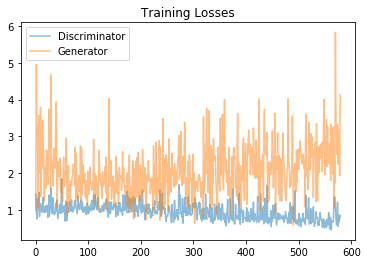

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of our trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples_copy3.pkl', 'rb') as f:
    samples = pkl.load(f)

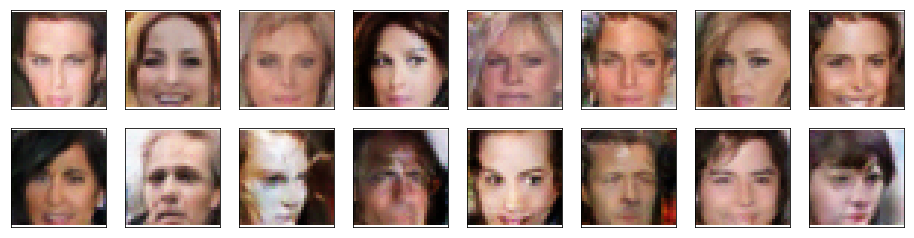

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
Consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

I tried different hyperparameters and optimizer, below shows what I learned, and guess would help improve.
- **Higher Resolution Inputs:** As we can see the input size we used is 32x32, compared to the original size 64x64, the resolution of 32x32 image is relatively low. Hence, it might be helpful to use higher resolution pictures, but it will take more computational time.

<img src='assets/imgsize32.png' width=40% />

> Image size 32 x 32

<img src='assets/imgsize64.png' width=40% />

> Image size 64 x 64

- **Increasing Epoches:** Very straight forward results which you can see below.

<img src='assets/SGD_epoch2.png' width=40% />

> 2 Epoches (SGD)

<img src='assets/SGD_epoch12.png' width=40% />

> 12 Epoches (SGD)


- **Changing Optimizer:** I tried SGD and Adam optimizer separately, and find out that Adam was doing a better job.

<img src='assets/adam_epoch10.png' width=40% />

> 10 Epoches (Adam)

<img src='assets/SGD_epoch12.png' width=40% />

> 12 Epoches (SGD)



- **Using Different lr:** I tried to use different learning rate in discriminator and generator. Make sure I set `d_lr` > `g_lr` because I don't want my generator being so aggressive, I want it as a hunter who approaches his prey slowly step by step.

<img src='assets/same_lr.png' width=40% />

> Same learning rate (d_lr = g_lr = 0.0002)

<img src='assets/diff_lr.png' width=40% />

> Different learning rate (d_lr = 0.0002, g_lr = 0.0001)


- **Label Smoothing:** I set the label from 1 to 0.9 and found this tip works well as it makes the discriminator wasn't overconfident about its classification.

- **Adding Noise:** We can do data augmentation, say rotation, crop, flip and so on, during other deep learning projects such as Flower Classification. But there's no data augmentation in GAN. So... How could we avoid overfitting or instability when we train a GAN model? Some papers show that it would be beneficial to add noise to both real and generated data.




